In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from schema_creation import connection

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 9)

conn = connection(password='8nqw$NS54Yh7FgWU', database="vet_clinic")
cur = conn.cursor()

connected to @localhost on port 3306


# Przygotuj wykres przedstawiający liczbę wizyt każdego dnia

<AxesSubplot:>

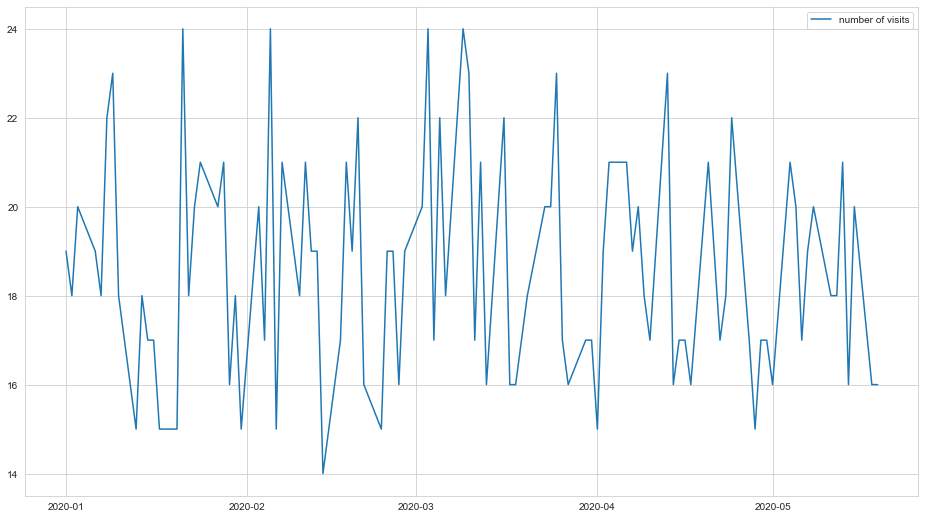

In [7]:
cur.execute('''select date(real_date), count(*) from visits where real_date is not null
group by year(real_date), month(real_date), day(real_date);
''')

records = cur.fetchall()
dates = []
novs = []
for date, nov in records:
    dates.append(date)
    novs.append(nov)

df = pd.DataFrame(data={'number of visits': novs[:100]}, index=dates[:100])
sns.lineplot(data=df)

# Przygotuj wykres przedstawiający bilans zysków i strat kliniki.

<AxesSubplot:xlabel='months', ylabel='amount'>

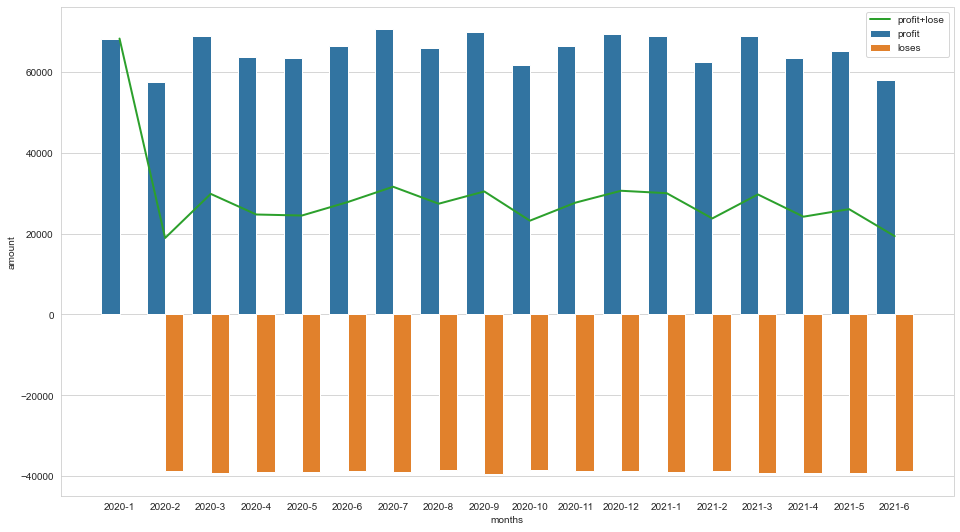

In [8]:
cur.execute('''with t1 as (
    select concat(year(date),'-', month(date)) as month_, sum(amount) as profits
    from cash_flow where amount >= 0 group by year(date), month(date)),
t2 as (
    select concat(year(date),'-', month(date)) as month_, sum(amount) as loses
    from cash_flow where amount < 0 group by year(date), month(date))
select month_, profits, 'profit' from t1
union all
select month_, loses, 'loses' from t2;''')

records = cur.fetchall()
months = []
amount = []
p_or_l = []
for date, am, pl in records:
    months.append(date)
    amount.append(am)
    p_or_l.append(pl)

df = pd.DataFrame(data={'amount': amount, 'profit_or_lose':p_or_l, 'months':months})
sns.barplot(data=df, x='months', y='amount', hue='profit_or_lose')

cur.execute("""select concat(year(date),'-', month(date)) as month_, sum(amount) from cash_flow
                group by year(date), month(date)""")

records = cur.fetchall()
months = []
diff = []
for date, d in records:
    months.append(date)
    diff.append(d)

df = pd.DataFrame(data={'diff': diff, 'months':months})
sns.lineplot(x='months', y='diff', data=df, color='C2', zorder=5, lw=2, label='profit+lose')

# Stwórz listę zwierzaków najdłużej czekających na wizytę.

In [18]:
cur.execute("""select petID, max(timestampdiff(hour,registration_date, planned_date)) as `max_wait`
                from visits group by petID order by `max_wait` DESC limit 20;""")

records = cur.fetchall()
petid = [record[0] for record in records]
wait_time = [record[1] for record in records]
df = pd.DataFrame(data={'petID': petid, 'wait_time (hours)':wait_time})
df

,petID,wait_time (hours)
0,203,356
1,299,356
2,76,356
3,77,356
4,253,356
5,223,356
6,241,356
7,51,356
8,260,356
9,37,356


# rozkład wagi zwierząt

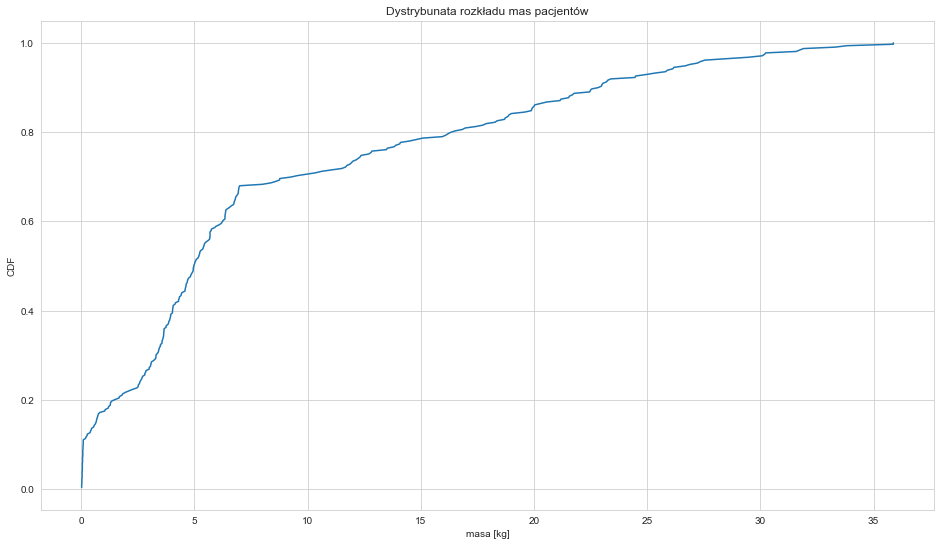

In [10]:

cur.execute('''select weight from pets;
''')

records = cur.fetchall()
data = [float(record[0]) for record in records]
n = len(data)
Cumsum = np.cumsum(np.ones((1,n))/n)

plt.plot(sorted(data), Cumsum)
plt.xlabel('masa [kg]')
plt.ylabel('CDF')
plt.title("Dystrybunata rozkładu mas pacjentów")
plt.show()


# zarobki lekarzy w stosunku do przychodów z wizyt

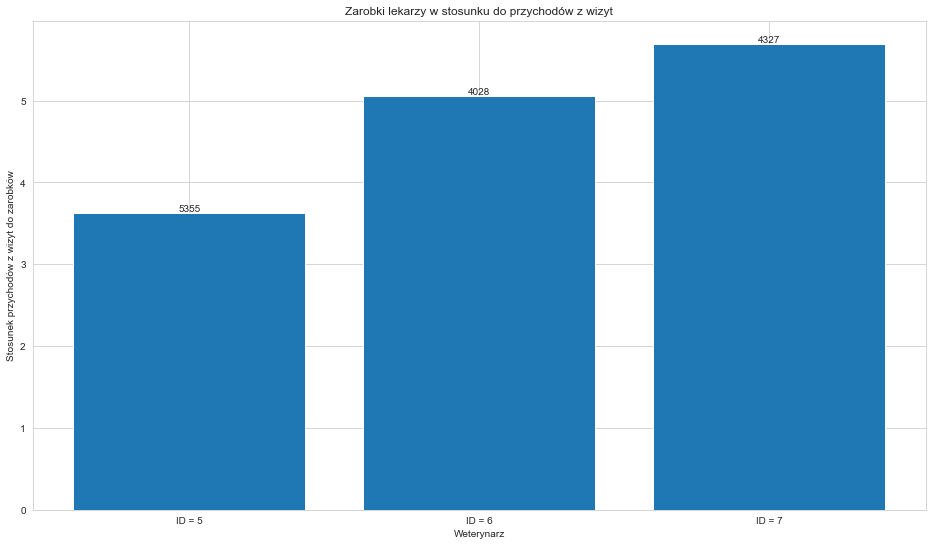

In [11]:
cur.execute('''select salary, employeeID from employees where position = 'Weterynarz';
''')

records1 = cur.fetchall()

cur.execute('''select employeeID, sum(cost) from visits where real_date is not null
group by employeeID, year(real_date), month(real_date) ;
''')
records2 = cur.fetchall()
records2 = [(item[0], int(item[1])) for item in records2]
df = pd.DataFrame(data={'vet': [item[0] for item in records2], 'sum': [item[1] for item in records2]})
df = df.groupby('vet').agg(np.mean).reset_index()
df['sum'] = df['sum']/[int(it[0]) for it in records1]

xdata = df['vet']
ydata = df['sum']
x_labels = [int(it[0]) for it in records1]

line = plt.bar(xdata, ydata)
plt.xlabel("Weterynarz")
plt.ylabel("Stosunek przychodów z wizyt do zarobków")

for i in range(len(ydata)):
    plt.annotate(x_labels[i], xy = (xdata[i], ydata[i]),ha='center', va = 'bottom')

plt.xticks(xdata,[f'ID = {it}' for it in xdata])
plt.title("Zarobki lekarzy w stosunku do przychodów z wizyt")
plt.show()

# najczęściej przepisywane leki

In [12]:
cur.execute('''select drugID, sum(amount), name from meds_prescribed left join meds using (drugID)
group by drugID order by sum(amount) desc limit 20 ;
''')
records = cur.fetchall()

pd.DataFrame(data = {'id': [it[0] for it in records], 'name': [it[2] for it in records], 'total quantity': [it[1] for it in records] })

,id,name,total quantity
0,39,diazepam,223.0
1,90,oxibendazole,219.0
2,9,amoxicillin,216.0
3,107,pregabalin,209.0
4,92,oxytetracycline,209.0
5,12,atenolol,208.0
6,13,atipamezole,207.0
7,4,amantadine,207.0
8,91,oxymorphone,206.0
9,7,amitriptyline,203.0


# procentowy podział strat

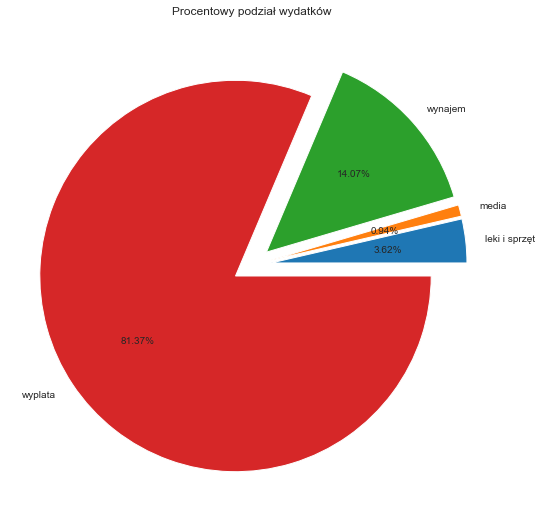

In [16]:
cur.execute('''select avg(x), type from (select sum(amount) as 'x', type from cash_flow where amount < 0 group by type, year(date), month(date)) as zzz group by type;
''')

records = cur.fetchall()

plt.pie([int(-1*it[0]) for it in records], labels=[it[1] for it in records],autopct='%0.2f%%', explode=[0.1]*4)
plt.title("Procentowy podział wydatków")
plt.show()